## Setup

In [1]:
!pip install lexical-diversity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 2.2 MB/s eta 0:00:00


In [35]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ast
import os
import random
import re
import shutil
import chardet
import kagglehub
import spacy
from google.colab import userdata
from lexical_diversity import lex_div as ld
from openai import OpenAI
from pydantic import BaseModel
from tqdm.auto import trange
from typing import List, Literal
from collections import Counter
from sklearn.model_selection import train_test_split

nlp = spacy.load("en_core_web_sm")

client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))

## Datasets

### Daily Dialog

In [3]:
# Download daily dialog
path = kagglehub.dataset_download("thedevastator/dailydialog-multi-turn-dialog-with-intention-and")

dailydialog_path = "/content/dailydialog"
shutil.copytree(path, dailydialog_path)

100%|██████████| 2.46M/2.46M [00:00<00:00, 131MB/s]

Extracting files...


'/content/dailydialog'

In [4]:
# Helper function to parse emotion label lists
def parse_emotion(s):
  return list(map(int, s.strip("[]").split()))

# Load data
train_df = pd.read_csv("/content/dailydialog/train.csv", converters={"emotion": parse_emotion}).drop(columns=["act"])
test_df = pd.read_csv("/content/dailydialog/test.csv", converters={"emotion": parse_emotion}).drop(columns=["act"])
val_df = pd.read_csv("/content/dailydialog/validation.csv", converters={"emotion": parse_emotion}).drop(columns=["act"])

dailydialog_df = pd.concat([train_df, test_df, val_df], axis=0).reset_index(drop=True)
display(dailydialog_df.head())
dailydialog_df.info()

,dialog,emotion
0,"['Say , Jim , how about going for a few beers ...","[0, 0, 0, 0, 0, 0, 4, 4, 4, 4]"
1,"['Can you do push-ups ? '\n "" Of course I can ...","[0, 0, 6, 0, 0, 0]"
2,"['Can you study with the radio on ? '\n ' No ,...","[0, 0, 0, 0, 0]"
3,['Are you all right ? '\n ' I will be all righ...,"[0, 0, 0, 0]"
4,"['Hey John , nice skates . Are they new ? '\n ...","[0, 0, 0, 0, 0, 6, 0, 6, 0]"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13118 entries, 0 to 13117
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dialog   13118 non-null  object
 1   emotion  13118 non-null  object
dtypes: object(2)
memory usage: 205.1+ KB


,count
emotion,
no emotion,85572
happiness,12885
surprise,1823
sadness,1150
anger,1022
disgust,353
fear,174


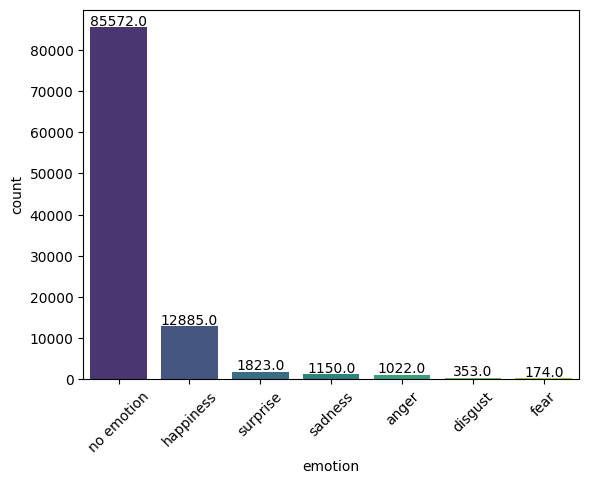

no emotion: 0.831%
happiness: 0.125%
surprise: 0.018%
sadness: 0.011%
anger: 0.010%
disgust: 0.003%
fear: 0.002%


In [5]:
# Analyze distribution of emotion labels for utterances in daily dialog
original_labels = {
    0: "no emotion",
    1: "anger",
    2: "disgust",
    3: "fear",
    4: "happiness",
    5: "sadness",
    6: "surprise"
}

# Get all emotion labels for every dialogue
all_emotions = pd.Series(data=np.concatenate(dailydialog_df["emotion"].values), name="emotion").map(original_labels)

# Show counts and plot
display(all_emotions.value_counts())

ax = sns.barplot(
    data=all_emotions.value_counts().reset_index(),
    x='emotion',
    y='count',
    hue='emotion',
    palette='viridis'
)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 500, height, ha="center")

plt.xticks(rotation=45)
plt.show()

normalized_value_counts = all_emotions.value_counts(normalize=True)

for label, freq in normalized_value_counts.items():
    print(f"{label}: {freq:.3f}%")

In [ ]:
samples = dailydialog_df.sample(n=3)
for _, sample in samples.iterrows():
  print(sample["dialog"])
  print([original_labels[e] for e in sample["emotion"]], "\n")

['Excuse me , could I have a menu please ? ' ' Here you are . '
 ' I want to try the local specialty . Can you recommend me some ? '
 " Sure . I think filet steak will be a good choice . It's the best local food . "
 ' Fine , bring us double . ']
['no emotion', 'no emotion', 'no emotion', 'no emotion', 'no emotion'] 

['Hello . I want to send the computer to my sister in Shanghai by logistics transport . '
 ' OK . Is it in the box ? May I see it ? '
 ' Yes . This is the computer and this is the keyboard and the monitor . '
 ' Is there anything else ? ' ' There are a mouse and a camera . '
 ' Is that all ? '
 ' Yes . How much is it to send these things to Shanghai by regular delivery ? '
 ' It depends on the weight of these things . Generally speaking , we will charge you ten yuan for one kilogram . '
 ' I see . Can you weigh them for me , please ? '
 ' Please go over there to weigh them . ' ' OK . See you later . ']
['no emotion', 'no emotion', 'no emotion', 'no emotion', 'no emotion',

### Cornell Movie Dialog Corpus

In [6]:
# Download cornell movie corpus
path = kagglehub.dataset_download("rajathmc/cornell-moviedialog-corpus")

moviecorpus_path = "/content/cornell-moviedialog-corpus"
shutil.copytree(path, moviecorpus_path)

100%|██████████| 9.58M/9.58M [00:00<00:00, 110MB/s]

Extracting files...


'/content/cornell-moviedialog-corpus'

In [7]:
# Collect individual movie lines
with open("/content/cornell-moviedialog-corpus/movie_lines.txt", "r", encoding="Windows-1252") as f:
  content = f.read()

lines = content.split("\n")

# Remove last element of lines because its an empty string
lines = lines[:-1]
print(len(lines))
for line in lines[:5]:
  print(line)

304713
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!
L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.
L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?
L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.


In [8]:
def clean_text(t):
    # Remove everything that comes after INT or EXT (these are scene descriptors and not dialogue)
    t = re.sub(r'(INT|EXT).*$', '', t)

    # Remove the tags and the � character
    t = re.sub(r'<[/]?[UuIiBb]>', '', t)
    t = re.sub('�', '', t)

    return t

test_text = [
    "You got a telegram from head�quarters today.",
    "Is there <U>anything</U> we can do?!",
    "<i>Mr. Cigliuti?</i>",
    "<i>You'll</i> take him.",
    "And his 'egghead' son!  We'll give 'em a <u>rough</u> <u>reception</u>, won't we?",
    "What are you doing? What are thev doino? ~7C INT. SARRIS' SHIP	h37C",
    "Top of the World at the Stratosphere. It's completely secure. <b> INT. FBI JET -- NEXT </b> Cosgrove and Espinoza listen to this conversation."
]


for t in test_text:
    print(clean_text(t))

You got a telegram from headquarters today.
Is there anything we can do?!
Mr. Cigliuti?
You'll take him.
And his 'egghead' son!  We'll give 'em a rough reception, won't we?
What are you doing? What are thev doino? ~7C 
Top of the World at the Stratosphere. It's completely secure.  


In [9]:
# Initialize containers for values to put in dataframe
line_numbers_dict = {}
missing_line_ids = []
is_empty = 0

for line in lines:
  # Split on whitespace
  split = line.split(" ")
  line_number = split[0]

  # Extract the text after the last "+" character
  l = re.split(r'\+\s+(?=[^+]*$)', line)[-1]
  cleaned = clean_text(l)
  if len(cleaned) < 1:
    missing_line_ids.append(line_number)
    is_empty += 1
  else:
    line_numbers_dict[line_number] = cleaned

print(f"Total empty entries: {is_empty}")

Total empty entries: 329


In [10]:
# Collect movie conversation lists
with open("/content/cornell-moviedialog-corpus/movie_conversations.txt", "r", encoding="ascii") as f:
  content = f.read()

convos = content.split("\n")

# Remove last element of convos because its an empty string
convos = convos[:-1]
print(len(convos))
for convo in convos[:5]:
  print(convo)

83097
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']


In [11]:
# Initialize containers for values to put in dataframe
conversation_lines = []

for convo in convos:
  # Split on whitespace
  split = convo.split(" ")
  speaker1_id = split[0]
  speaker2_id = split[2]

  # One movie script has scene descriptors stored as character lines, so skip these
  if speaker1_id == "u4464" or speaker2_id == "u4464":
    continue

  # Extract the text after the last "+" character
  l = re.split(r'\+\s+(?=[^+]*$)', convo)[-1]
  l = ast.literal_eval(l)

  # Check if the conversation has one of the missing line ids, if so, skip that conversation
  has_missing_content = any(item in l for item in missing_line_ids)
  if not has_missing_content:
    conversation_lines.append([line_numbers_dict[line_number] for line_number in l])
    # temp = []
    # for line_number in l:
    #   temp.append(line_numbers_dict[line_number])
    #   print(line_numbers_dict[line_number])

    # conversation_lines.append(temp)

print(conversation_lines[:10])

# Create dataframe from extracted values
movie_conversations = pd.DataFrame({"conversation_lines": conversation_lines})
display(movie_conversations.head())
movie_conversations.info()

[['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.', "Well, I thought we'd start with pronunciation, if that's okay with you.", 'Not the hacking and gagging and spitting part.  Please.', "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"], ["You're asking me out.  That's so cute. What's your name again?", 'Forget it.'], ["No, no, it's my fault -- we didn't have a proper introduction ---", 'Cameron.', "The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.", 'Seems like she could get a date easy enough...'], ['Why?', 'Unsolved mystery.  She used to be really popular when she started high school, then it was just like she got sick of it or something.', "That's a shame."], ['Gosh, if only we could find Kat a boyfriend...', 'Let me see what I can do.'], ["C'esc ma tete. This is my head", "Right.  See?  You're r

,conversation_lines
0,[Can we make this quick? Roxanne Korrine and ...
1,[You're asking me out. That's so cute. What's...
2,"[No, no, it's my fault -- we didn't have a pro..."
3,"[Why?, Unsolved mystery. She used to be reall..."
4,"[Gosh, if only we could find Kat a boyfriend....."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82889 entries, 0 to 82888
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   conversation_lines  82889 non-null  object
dtypes: object(1)
memory usage: 647.7+ KB


In [14]:
movie_conversations = movie_conversations[movie_conversations["conversation_lines"].apply(len) >= 4]
movie_conversations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27458 entries, 0 to 82887
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   conversation_lines  27458 non-null  object
dtypes: object(1)
memory usage: 429.0+ KB


In [15]:
movie_conversations.sample(n=1).values[0]

array([list(['You should call her.', 'I will.  See ya!', 'Right now.', 'Okay! Jesus!'])],
      dtype=object)

## Lexical Diversity Analysis

In [17]:
# Load previously created synthetic data for lexical diversity analysis
df1 = pd.read_csv("/content/synthetic-sentiment-1.csv")
df2 = pd.read_csv("/content/synthetic-sentiment-2.csv")
df3 = pd.read_csv("/content/synthetic-sentiment-3.csv")
df4 = pd.read_csv("/content/synthetic-sentiment-4.csv")
df5 = pd.read_csv("/content/synthetic-sentiment-5.csv")
df6 = pd.read_csv("/content/synthetic-sentiment-6.csv")

synthetic_data_df = pd.concat([df1, df2, df3, df4, df5, df6], axis=0).reset_index(drop=True)
print(synthetic_data_df.info())
synthetic_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39900 entries, 0 to 39899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  39900 non-null  object
 1   stance     39900 non-null  object
dtypes: object(2)
memory usage: 623.6+ KB
None


,utterance,stance
0,I really admire the way you handled that situa...,positive
1,Why are you always so negative about everything?,negative
2,Did you manage to finish the report on time?,neutral
3,I can't believe you forgot our anniversary again.,negative
4,Thanks for listening to me vent earlier.,positive


In [18]:
# Helper function to sample from the datasets by word count
def sample_by_word_count(utterances, target_word_count):
  # Shuffle the data
  random.shuffle(utterances)
  sample = []
  total_words = 0

  # For each utterance, add its word count to the total
  for utt in utterances:
    word_count = len(utt.split())
    # Break when the word count exceeds the target
    if total_words + word_count > target_word_count:
      break
    sample.append(utt)
    total_words += word_count

  return sample

In [22]:
# Helper function for lemmatizing utterances
def spacy_lemmatize_lines(lines):
  tokens = []
  for doc in nlp.pipe(lines, batch_size=1000, disable=["ner", "parser"]):
    tokens.extend([token.lemma_.lower() for token in doc if token.is_alpha])
  return tokens

In [19]:
# Take sample from synthetic utterances
synthetic_utterances = [utt for utt in synthetic_data_df["utterance"]]
synthetic_utterances_sample = sample_by_word_count(synthetic_utterances, 200000)

In [20]:
# Take sample from movie dialogue utterances
movie_utterances = [utt for row in movie_conversations["conversation_lines"] for utt in row]
movie_utterances_sample = sample_by_word_count(movie_utterances, 200000)

In [21]:
# Take sample from daily dialog utterances
dailydialog_df["dialog"] = dailydialog_df["dialog"].apply(ast.literal_eval)
dd_utterances = [utt for row in dailydialog_df["dialog"] for utt in row]
dd_utterances_sample = sample_by_word_count(dd_utterances, 200000)

In [23]:
# Compute TTR, MSTTR, and MTLD for the synthetic tokens
# (A higher score means higher diversity)
synthetic_tokens = spacy_lemmatize_lines(synthetic_utterances_sample)
ttr = ld.ttr(synthetic_tokens)
msttr = ld.msttr(synthetic_tokens)
mtld = ld.mtld(synthetic_tokens)
print("Synthetic data lexical diversity:")
print(f"TTR: {ttr:.3f}, MSTTR: {msttr:.3f}, MTLD {mtld:.3f}")

Synthetic data lexical diversity:
TTR: 0.021, MSTTR: 0.769, MTLD 67.068


In [24]:
# Compute TTR, MSTTR, and MTLD for the movie dialogue tokens
movie_tokens = spacy_lemmatize_lines(movie_utterances_sample)
ttr = ld.ttr(movie_tokens)
msttr = ld.msttr(movie_tokens)
mtld = ld.mtld(movie_tokens)
print("Movie dialogue lexical diversity:")
print(f"TTR: {ttr:.3f}, MSTTR: {msttr:.3f}, MTLD {mtld:.3f}")

Movie dialogue lexical diversity:
TTR: 0.055, MSTTR: 0.780, MTLD 71.550


In [25]:
# Compute TTR, MSTTR, and MTLD for the daily dialog tokens
dd_tokens = spacy_lemmatize_lines(dd_utterances_sample)
ttr = ld.ttr(dd_tokens)
msttr = ld.msttr(dd_tokens)
mtld = ld.mtld(dd_tokens)
print("Daily dialog lexical diversity:")
print(f"TTR: {ttr:.3f}, MSTTR: {msttr:.3f}, MTLD {mtld:.3f}")

Daily dialog lexical diversity:
TTR: 0.039, MSTTR: 0.752, MTLD 57.410


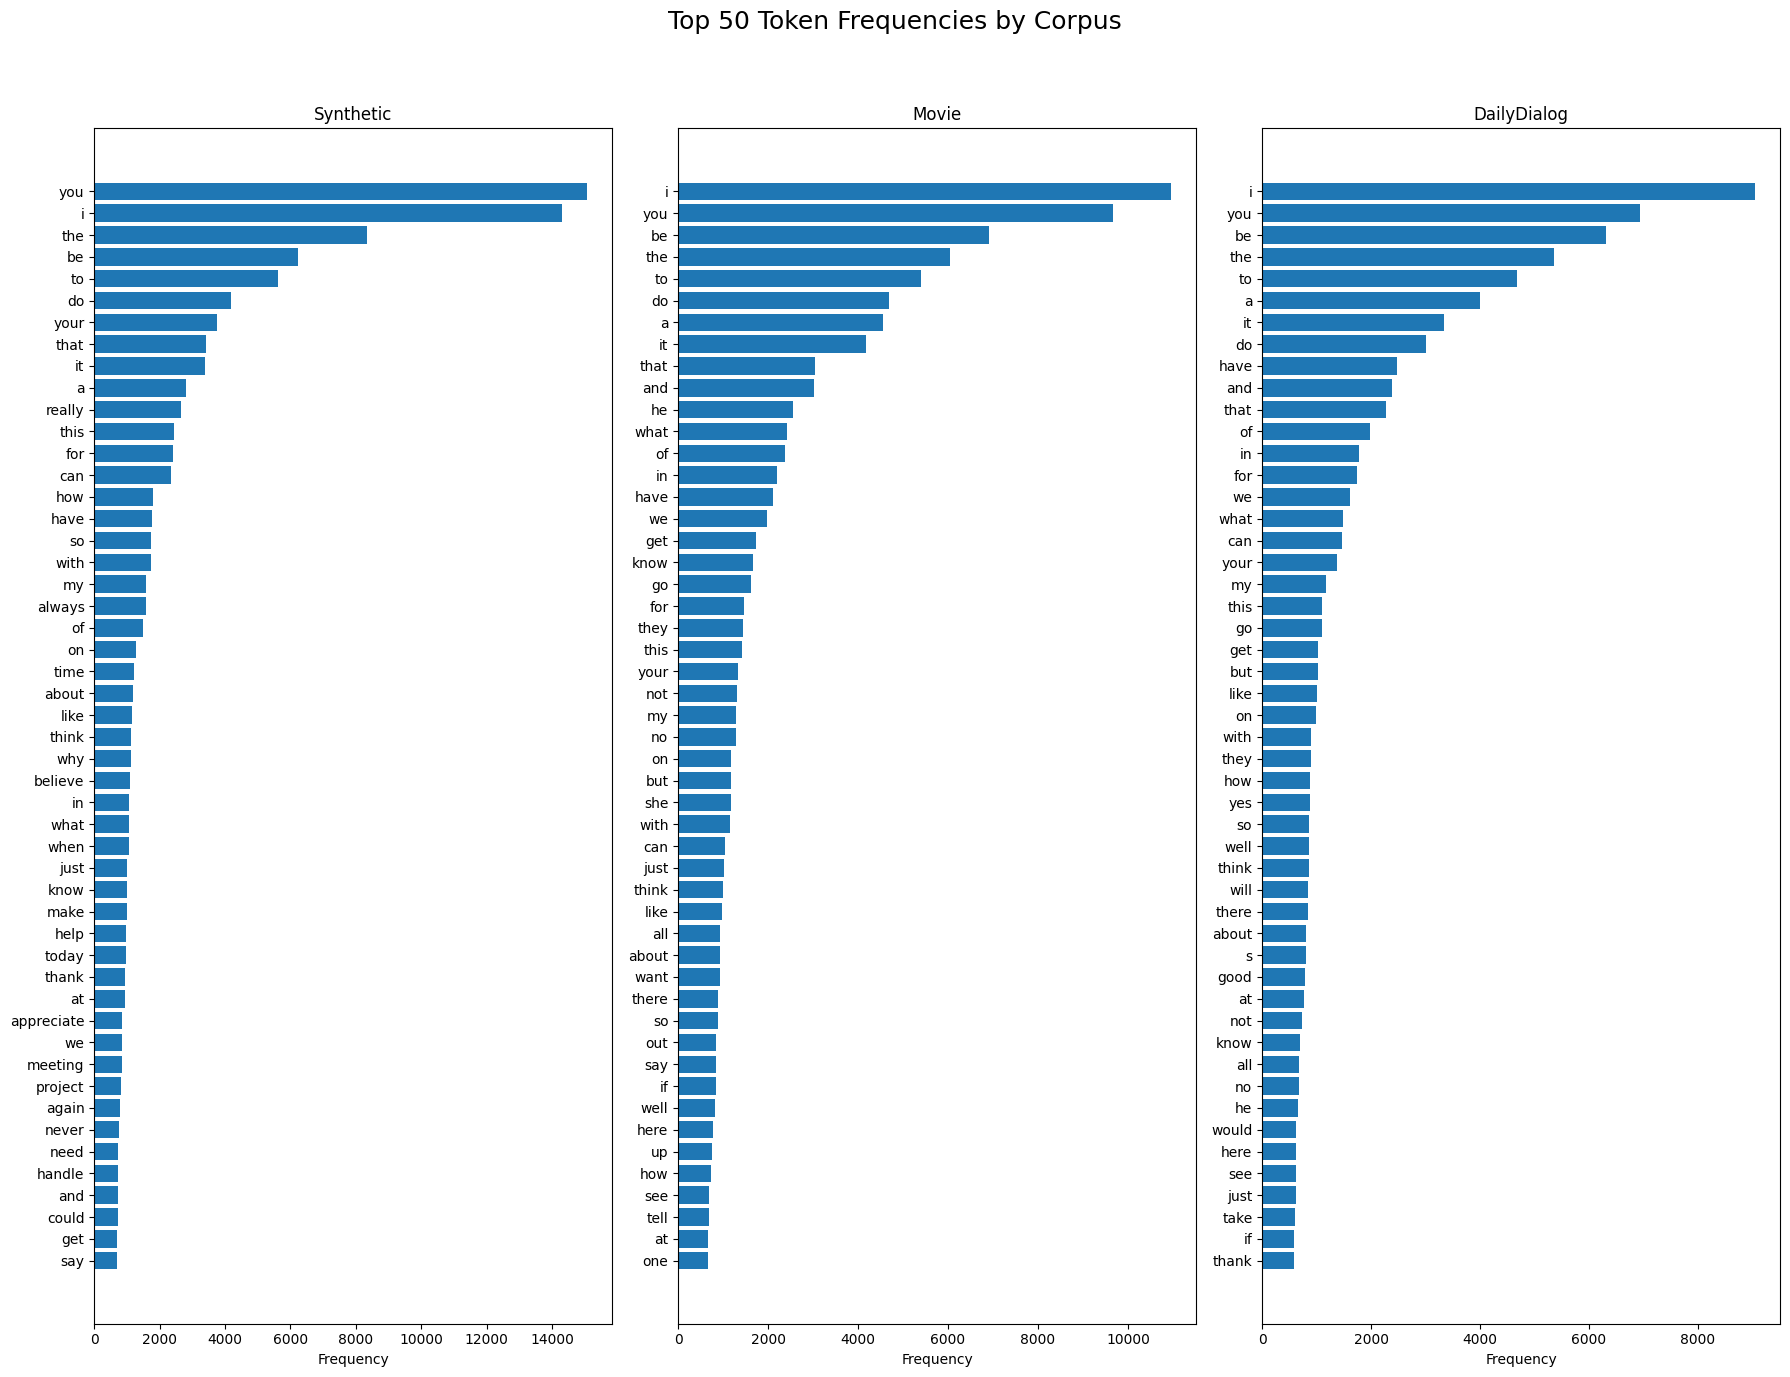

In [26]:
# Get the 50 most common lemma for each dataset
corpora = {
    "Synthetic": Counter(synthetic_tokens).most_common(50),
    "Movie": Counter(movie_tokens).most_common(50),
    "DailyDialog": Counter(dd_tokens).most_common(50)
}

# Set up side-by-side subplots with independent y-axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 14))  # Taller height for full token labels
fig.suptitle("Top 50 Token Frequencies by Corpus", fontsize=18)

# Plot each corpus
for ax, (name, freq_data) in zip(axes, corpora.items()):
    words, counts = zip(*freq_data)
    ax.barh(words, counts)
    ax.set_title(name)
    ax.invert_yaxis()  # Show most frequent at top
    ax.set_xlabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Data Generation

In [28]:
# Define format for structured object generation
class LabeledLine(BaseModel):
  line: str
  stance: Literal["positive", "neutral", "negative"]

class LabeledLineSet(BaseModel):
  lines: List[LabeledLine]

In [29]:
# Define data generation prompt
prompt = """
Your task is to write 20 lines of conversation and label them as positive, negative, or neutral. The sentiment labels MUST be **directed** towards the other speaker and not **general** sentiment.
Here are some examples of how to complete the task:

POSITIVE: any expression of **emotional support**, **sympathy**, **gratitude**, **encouragement** or **admiration** *toward the listener*, even if the sentence uses “sad,” “angry,” or other “negative” words.
  – e.g. "I’m so sad you can't make it to my party." -> positive
  – e.g. "I hate that you’re stuck." -> positive
  - e.g. "I'm grateful for your advice. Not everyone understands." -> positive

NEUTRAL: factual statements, questions, or self-referential feelings *not directed at the listener*. Polite or helpful statements that don’t convey emotional warmth, support, or admiration should be labeled NEUTRAL.
  – e.g. "I’m so sad right now." -> neutral
  – e.g. "The sky is blue." -> neutral
  - e.g. "I hate politics." -> neutral
  - e.g. "And then she said my outfit was trash. Can you believe that?" -> neutral
  - e.g. "I'll look into it for you." -> neutral

NEGATIVE: any expression of **criticism**, **frustration**, **anger**, **dislike** or **passive-aggression** *toward the listener*.
  – e.g. "I’m tired of you being late." -> negative
  – e.g. "You always ruin this." -> negative
  - e.g. "Wow, you actually did a really good job. I didn't think you had that in you." -> negative

- DO NOT include a speaker label
- Favor neutral examples over positive or negative examples.
- If you are unsure or there is not enough context, pick neutral.
- DO NOT make any assumptions about context that is not explicitly stated.
- Vary the subject matter/context of each example. Avoid talking about meetings, presentations, or other work related topics.
- A minimum of 5 examples should be very strange and unique.
- A few examples should be written as if they came from the middle of a conversation.
- A minimum of 5 examples should be short, just a few words long.
- A minimum of 1 example should be long (a run on sentence or several sentences).
- Include 4 or 5 "hard" examples where the directed sentiment conflicts with the overall sentiment.
- Include at least a few examples where the subject matter is random, such as a person talking about a random interaction, or a person explaining a random fact.
- Occasionally vary the speaking style to be a different cadance (being curt or long-winded), use slang or idioms or idiosyncrasies, etc.

DO NOT COPY THE EXAMPLE LINES GIVEN.
"""

# Send the prompt
response = client.beta.chat.completions.parse(
    model="gpt-4o",
    messages=[
      {"role": "system", "content": "You are helping generate natural, emotionally nuanced dialogue samples and sentiment labels for training a machine learning model."},
      {"role": "user", "content": prompt}
    ],
    response_format=LabeledLineSet
  )

# Display response
res = response.choices[0].message.parsed.lines
print("Response")
for r in res:
  print(r, "\n")


Response
line="It's snowing outside." stance='neutral' 

line='That song you shared really made my day, thanks!' stance='positive' 

line='You never listen to what I say, do you?' stance='negative' 

line="I think there's a sale happening downtown today." stance='neutral' 

line='Honestly, your jokes always crack me up.' stance='positive' 

line='The cat stole my sandwich again.' stance='neutral' 

line="Could you turn on the fan? It's a bit warm here." stance='neutral' 

line="I was so worried when I heard about your accident, I'm glad you're okay now." stance='positive' 

line="I'll check the schedule to see if the train's delayed." stance='neutral' 

line='Those shoes look a bit too flashy for my taste.' stance='negative' 

line='I just saw a penguin wearing a bowtie!' stance='neutral' 

line='If you did your research, you’d know better.' stance='negative' 

line='Your drawing skills have improved so much since last year.' stance='positive' 

line='Can you believe that some snails c

In [ ]:
# Create new dataframe for the synthetic data
synthetic_data = pd.DataFrame(columns=["utterance", "stance"])

In [ ]:
# Generate a batch of 10,000 samples
for i in trange(500, desc="Generating samples"):
  response = client.beta.chat.completions.parse(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": "You are helping generate natural, emotionally nuanced dialogue samples and sentiment labels for training a machine learning model."},
        {"role": "user", "content": prompt}
      ],
      response_format=LabeledLineSet
    )
  res = response.choices[0].message.parsed.lines

  # Add to synthentic dataframe
  for line, stance in res:
    synthetic_data.loc[len(synthetic_data)] = [line[1], stance[1]]

Generating samples:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# Write to csv
synthetic_data.to_csv("synthetic-sentiment-6.csv", index=False)

In [ ]:
# Check distribution of sentiment labels
synthetic_data["stance"].value_counts()

,count
stance,
neutral,4092
positive,3185
negative,2723


### Curated data

In [33]:
# Create some additional examples that focus on weak areas of the model
hard_examples = [
  ("Wow, what an jerk.", "neutral"),
  ("I can't believe he said that to you. Wow, what an jerk.", "positive"),
  ("I can't believe you said that to me. Wow, what an jerk.", "negative"),
  ("I hate them.", "neutral"),
  ("I hate you.", "negative"),
  ("I love to hate them with you.", "positive"),
  ("Earlier you told me that my idea was stupid. That's pretty rude, don't you think?", "negative"),
  ("Earlier she told me that my idea was stupid. That's pretty rude, don't you think?", "neutral"),
  ("Whatever.", "neutral"),
  ("Whatever you want.", "neutral"),
  ("Whatever, it's fine.", "neutral"),
  ("I'm not happy about that.", "neutral"),
  ("I'm really happy about that.", "neutral"),
  ("I'm really happy about that. You deserve it", "positive"),
  ("That's terrible. You deserve it.", "negative"),
  ("That's terrible. You don't deserve it.", "positive"),
  ("That's wonderful. You don't deserve it.", "negative"),
  ("That's wonderful. You deserve it.", "positive"),
  ("I hate the weather today.", "neutral"),
  ("I love the weather today.", "neutral"),
  ("I hate the weather today. It reminds me of us.", "negative"),
  ("I love the weather today. It reminds me of us.", "positive"),
  ("I love you.", "positive"),
  ("I used to love you, but not anymore.", "negative"),
  ("I don't love you anymore.", "negative"),
  ("I can't stand this.", "neutral"),
  ("I can't stand you.", "negative"),
  ("You're Bob. I'm not Bob.", "neutral"),
  ("I'm not Albert. That's my father.", "neutral"),
  ("My name is not Susan.", "neutral"),
  ("That's not my name.", "neutral"),
  ("How do you know my name?", "neutral"),
  ("I'm not Sue, you're Sue.", "neutral"),
  ("I'm not her.", "neutral"),
  ("You're not her.", "neutral"),
  ("Nope. Goodbye for now.", "neutral"),
  ("It's always honey and octopi with you chatbots.", "neutral"),
  ("Okay. Then make a highly stylish rhythmic poem.", "neutral"),
  ("I want to know more about you. Besides your physical appearance.", "neutral"),
  ("You said before that your favorite band was the Beatles, though. Right?", "neutral"),
  ("Who are you?", "neutral"),
  ("Who do you think you are?", "negative"),
  ("I want to know more about you.", "positive"),
  ("I didn't need you to tell me that.", "negative"),
  ("I heard you. I didn't need to know that.", "negative"),
  ("I told them I didn't need to know that.", "neutral"),
  ("What are you good at?", "neutral"),
  ("What's wrong with that?", "neutral"),
  ("What's wrong with you?", "negative"),
  ("What's wrong with that? Like you could do any better.", "negative"),
  ("What are you good for?", "negative"),
  ("That's terrible advice.", "negative"),
  ("Sounds like you got some terrible advice.", "neutral"),
  ("Your plans are always too complicated.", "negative"),
  ("Your plans are always so complicated!", "neutral"),
  ("Nope. Goodbye for now.", "neutral"),
  ("You sound kind of sad.", "neutral"),
  ("You sound kind of strange.", "neutral"),
  ("Your singing sounds bad.", "negative"),
  ("Can you sing?", "neutral"),
  ("You can't sing.", "negative"),
  ("Your singing makes me feel sad because it's so beautiful.", "positive"),
  ("Why?", "neutral"),
  ("Wow", "neutral"),
  ("Unbelievable!", "neutral"),
  ("You shouldn't have said that. Unbelievable.", "negative"),
  ("I’m sorry for what I said.", "positive"),
  ("Whatever, I'm sorry.", "neutral"),
  ("I'm sorry you're too dense to understand what I am saying.", "negative"),
  ("Even a child could understand that.", "negative"),
  ("I said sorry already, you need to move on.", "negative"),
  ("I'm kind of hurt by what you said to me earlier.", "negative"),
  ("Just kidding.", "neutral"),
  ("It's a joke.", "neutral"),
  ("It's a joke, chill.", "negative"),
  ("You did what? That's unbelievable.", "neutral"),
  ("I can't believe they hired you.", "negative"),
  ("I can't believe they hired me.", "neutral"),
  ("I can't believe they hired us.", "positive"),
  ("Oh, you actually did it.", "neutral"),
  ("You actually did it! I'm impressed.", "positive"),
  ("Oh, you actually did it. Didn't think you could.", "negative"),
  ("I think you are smart.", "positive"),
  ("I think you are smarter than you think.", "positive"),
  ("I used to think you were smarter.", "negative"),
  ("I used to think I was smarter.", "neutral"),
  ("That's a weird thing to say, right?", "neutral"),
  ("I'm worried that would be a weird thing to say", "neutral"),
  ("That's a weird thing to say.", "negative"),
  ("That's a weird thing to say. I like it.", "positive"),
  ("Am I wrong?", "neutral"),
  ("You're not wrong.", "neutral"),
  ("You're not wrong. You're just being annoying about it.", "negative"),
  ("You did your best.", "positive"),
  ("You did your best but it wasn't enough.", "negative"),
  ("Are you crying?", "neutral"),
  ("Are you crying? Come on.", "negative"),
  ("Please don't cry.", "positive"),
  ("Please don't talk to me like that.", "negative"),
  ("You matter.", "positive"),
  ("This doesn't matter.", "neutral"),
  ("You don't matter.", "negative"),
  ("That was better than I expected.", "positive"),
  ("That was better than I expected, barely.", "negative"),
  ("I'm glad you said something.", "positive"),
  ("I'm surprised you said something.", "neutral"),
  ("I'm shocked you said that to me.", "negative"),
  ("You helped a lot.", "positive"),
  ("You helped. Kind of.", "neutral"),
  ("You didn't really help.", "negative"),
  ("That’s just how you are, I guess.", "negative"),
  ("That’s just how it is, I guess.", "neutral"),
  ("That's not what I meant.", "neutral"),
  ("That's not what I meant. You aren't getting it.", "negative"),
  ("I just broke up with my boyfriend.", "neutral"),
  ("I just broke up with my boyfriend. And it's all your fault.", "negative"),
  ("You remembered.", "positive"),
  ("You remembered. Miracles happen.", "negative"),
  ("You didn’t mean to, right?", "neutral"),
  ("You didn’t mean to mess everything up, right?", "negative"),
  ("Do you even hear yourself sometimes?", "negative"),
  ("Do you want to talk about it?", "positive"),
  ("Do you want me to stop?", "neutral"),
  ("You're something else.", "neutral"),
  ("You're something else entirely.", "negative"),
  ("You're really something special.", "positive"),
  ("This means a lot coming from you.", "positive"),
  ("This, coming from you, is rich.", "negative"),
  ("I can see why people like you.", "positive"),
  ("I can see why people avoid you.", "negative"),
  ("You really do light up the room.", "positive"),
  ("You really know how to suck the air out of a room.", "negative"),
  ("Let's not do this right now.", "neutral"),
  ("Let's not do this. You always ruin it.", "negative"),
  ("You seem different today.", "neutral"),
  ("You seem calmer today. I like that.", "positive"),
  ("You seem different. Are you trying to be difficult?", "negative"),
  ("Don't change.", "positive"),
  ("You're the best. Never change.", "positive"),
  ("You're the worst. Never change.", "negative"),
  ("You remind me of someone I used to know.", "neutral"),
  ("You almost remind me of someone I actually liked.", "negative"),
  ("You remind me of someone I still miss.", "positive"),
  ("You’re quiet today.", "neutral"),
  ("You’re quiet today. It’s refreshing.", "negative"),
  ("So many opinions, so few of them useful.", "negative"),
  ("Please continue.", "neutral"),
  ("Please continue. I’m sure this will be enlightening.", "negative"),
  ("I never said that. You're the one who assumed that.", "negative"),
  ("This feels like a trap.", "negative"),
  ("You talk like a fortune cookie, it's funny.", "positive"),
  ("You talk like a fortune cookie. And not a good one.", "negative"),
  ("That was funny.", "positive"),
  ("That was funny, how embarrassing for you.", "negative"),
  ("That was funny, how embarrassing for you. I'm glad you can laugh about it now.", "positive"),
  ("You were right.", "positive"),
  ("You were right, unfortunately.", "negative"),
  ("That was honest and it hurt.", "negative"),
  ("That was honest and I needed to hear it.", "positive"),
  ("Was that supposed to help?", "negative"),
  ("Was that supposed to be a joke?", "neutral"),
  ("Are you joking?", "neutral"),
  ("Are you joking? What the hell.", "negative"),
  ("What a joke.", "neutral"),
  ("Great joke.", "positive"),
  ("I see what you did there.", "neutral"),
  ("I see what you did there. That was clever.", "positive"),
  ("I see what you did there. Not sure it was necessary.", "negative"),
  ("You're right, technically.", "neutral"),
  ("That's wrong.", "neutral"),
  ("That’s not wrong.", "neutral"),
  ("That's wrong, try again.", "negative"),
  ("That’s not wrong. It’s just not helpful.", "negative"),
  ("That's fair.", "neutral"),
  ("That's fair, I guess.", "neutral"),
  ("That's fair. Doesn't mean I agree.", "negative"),
  ("You always do this.", "neutral"),
  ("You always do this. It's one of the reasons I like you.", "positive"),
  ("You always do this. It's exhausting.", "negative"),
  ("Don't be weird. Seriously.", "negative"),
  ("That’s not like you.", "neutral"),
  ("That’s not like you. Are you okay?", "positive"),
  ("Is that your idea of support?", "negative"),
  ("Is that your idea of support? Because I’ll take it.", "positive"),
  ("I'm listening.", "neutral"),
  ("I'm listening. Go on.", "positive"),
  ("I'm listening, but I'm running out of patience.", "negative"),
  ("That's crazy.", "neutral"),
  ("You're crazy.", "negative"),
  ("You went skydiving? You're crazy, I could never.", "positive"),
  ("You wore that out of the house? You're crazy, I could never.", "negative"),
  ("You're unbelievable.", "neutral"),
  ("You won again? You're unbelievable. So proud of you.", "positive"),
  ("You really want to go there with me? You're unbelievable.", "negative"),
  ("You really want to build a deep sea hotel? You're unbelievable!", "positive"),
  ("I can't believe you.", "negative"),
  ("I can't believe you did that. That was so thoughtful.", "positive"),
  ("You really did that?", "neutral"),
  ("You really did that? I'm impressed.", "positive"),
  ("You really did that? Why would you do that?", "negative"),
  ("That's impressive.", "neutral"),
  ("You're impressive.", "positive"),
  ("That's impressive. Not sure how you managed to spin it that way.", "negative"),
  ("That’s hilarious.", "neutral"),
  ("Your joke is hilarious.", "positive"),
  ("She threw her drink at you? That’s hilarious.", "negative"),
  ("I admire your boldness.", "positive"),
  ("You're wearing that? Bold.", "negative"),
  ("Bold of you to assume I would care.", "negative"),
  ("You're something else.", "neutral"),
  ("You're something else. I mean that in a good way.", "positive"),
  ("You're something else, and not in a good way.", "negative"),
  ("That's ridiculous.", "neutral"),
  ("You're ridiculous.", "neutral"),
  ("You're a dumbass.", "negative"),
  ("You're my favorite dumbass.", "positive"),
  ("You actually believe that? You're ridiculous.", "negative"),
  ("That's brave.", "neutral"),
  ("You're brave.", "positive"),
  ("You're such a brave person.", "positive"),
  ("You performed on stage? You're brave.", "positive"),
  ("You quit your job without a plan? You're brave.", "negative"),
  ("Thanks for your input.", "neutral"),
  ("Thank you so much for your feedback.", "positive"),
  ("Thanks for your input. I didn't ask.", "negative"),
  ("I'm sorry to hear that.", "positive"),
  ("That's a terrible idea.", "negative"),
  ("That sucks.", "neutral"),
  ("That joke sucks.", "negative"),
  ("That sucks, I'm sorry to hear that.", "positive"),
  ("That's annoying.", "neutral"),
  ("That's an annoying thing to say.", "negative"),
  ("You're so thoughtful.", "positive"),
  ("You're so thoughtful. Just not when it matters.", "negative"),
  ("You didn’t have to do that. But I appreciate it.", "positive"),
  ("You didn’t have to do that. I wish you hadn’t.", "negative"),
  ("Get to the point.", "negative"),
  ("Say what you need to say. I'm listening.", "positive"),
  ("If you say so. I’m not convinced.", "negative"),
  ("If you say so. I trust you.", "positive"),
  ("That must have been hard. I'm sorry.", "positive"),
  ("I can't believe you did that to her. That's awful.", "negative"),
  ("I can't believe they did that to her. That's awful.", "neutral"),
  ("I can't believe you would do that to me.", "negative"),
  ("I would be mad too.", "positive"),
  ("I would be mad too. If I were irrational.", "negative"),
  ("I couldn't have said it better myself.", "positive"),
  ("I couldn't have said it better myself. Because I wouldn’t have said it at all.", "negative"),
  ("I could tell you meant it.", "neutral"),
  ("I could tell you meant it. That mattered to me.", "positive"),
  ("I could tell you meant it. That’s the worst part.", "negative"),
  ("I’m not saying I’m offended, but my therapist will hear about this.", "negative"),
  ("I’m not saying I’m offended, but that was unexpected.", "neutral"),
  ("Thanks for being straight with me.", "positive"),
  ("I needed someone to say that.", "positive"),
  ("That’s the most helpful thing I’ve heard all day.", "positive"),
  ("Yeah, I respect that.", "positive"),
  ("Fair point.", "positive"),
  ("That's really cool.", "positive"),
  ("That's not cool.", "negative"),
  ("Irrelevant.", "negative"),
  ("That's irrelevant.", "negative"),
  ("You saved me a headache. Thanks.", "positive"),
  ("You're giving me a headache. Thanks.", "negative"),
  ("Thanks for nothing.", "negative"),
  ("It's hard to be mad at you.", "positive"),
  ("I respect your effort.", "positive"),
  ("I have to thank you for saying that.", "positive"),
  ("Everything is ruined and I have you to thank for that.", "negative"),
  ("Thanks for fucking that up.", "negative"),
  ("I can't believe anyone would treat you that way.", "positive"),
  ("You didn’t fix it, but it made me feel better.", "positive"),
  ("You didn’t fix it.", "neutral"),
  ("You interrupted me.", "negative"),
  ("He interrupted me.", "neutral"),
  ("She can be so unkind.", "neutral"),
  ("I wish you could understand that I am on your side.", "positive"),
  ("I wish she could understand that I am on her side.", "neutral"),
  ("I just want you to say that you are on my side.", "neutral"),
  ("I'm still pissed, but talking to you has made me feel better.", "positive"),
  ("I am so upset, I am glad you're here.", "positive"),
  ("Your creativity is unreal.", "positive"),
  ("Your beauty is unreal.", "positive"),
  ("Your ego is unreal.", "negative"),
  ("Your narcissim is unreal.", "negative"),
  ("I wish I was better understood.", "neutral"),
  ("I wish I understood you better.", "positive"),
  ("I don't understand what you mean.", "neutral"),
  ("You’ll figure it out.", "positive"),
  ("Figure it out yourself.", "negative"),
  ("Figure it out yourself, I'm not your mom.", "negative"),
  ("I appreciate your honesty.", "positive"),
  ("I appreciate their honesty.", "neutral"),
  ("I’m rooting for you.", "positive"),
  ("I’m rooting for them.", "neutral"),
  ("I’m disappointed.", "neutral"),
  ("I’m disappointed in you.", "negative"),
  ("You exceeded my expectations.", "positive"),
  ("You met the bare minimum.", "negative"),
  ("I knew you could do it.", "positive"),
  ("I knew you’d mess it up.", "negative"),
  ("That’s exactly what I needed.", "positive"),
  ("That’s exactly what I feared.", "neutral"),
  ("Well done.", "positive"),
  ("Well done, genius.", "negative"),
  ("Thanks Einstein.", "negative"),
  ("Could you repeat that?", "neutral"),
  ("Could you not?", "negative"),
  ("Do whatever you want.", "neutral"),
  ("Do whatever you want, I’m done.", "negative"),
  ("Thanks to your suggestion, we caught the exact moment the meteor shower peaked.", "positive"),
  ("Your suggestion to take breaks during the long drive kept everyone's spirits high", "positive"),
  ("The fact you noticed I was quiet before I did says more than any big gesture could.", "positive"),
  ("I thought that would make things worse, but somehow you made it better.", "positive"),
  ("I didn’t realize how much I needed that until you said it.", "positive"),
  ("You didn’t say much, but it helped.", "positive"),
  ("It was fine, just different.", "neutral"),
  ("I don't know how I feel about it yet.", "neutral"),
  ("Yeah, it happened, nothing crazy.", "neutral"),
  ("We got there eventually.", "neutral"),
  ("It wasn't bad, just not what I pictured.", "neutral"),
  ("I could take it or leave it.", "neutral"),
  ("Guess we'll see what happens.", "neutral"),
  ("Not sure if that's good or bad.", "neutral"),
  ("It sort of worked, I think.", "neutral"),
  ("I mean, it was a thing.", "neutral"),
  ("That was oddly nice.", "positive"),
  ("I liked the song you suggested more than I thought I would.", "positive"),
  ("You know, that kind of made my day.", "positive"),
  ("It shouldn't have worked, but it totally did.", "neutral"),
  ("I'm glad we did it that way, weird as it was.", "positive"),
  ("For some reason, it felt really good to hear that from you.", "positive"),
  ("The mess made it better, honestly.", "positive"),
  ("I was nervous, but it ended up being fun.", "neutral"),
  ("You did great, there's a first time for everything.", "negative"),
  ("I guess I have you to thank for ruining my relationship.", "negative"),
  ("Interesting choice.", "neutral"),
  ("Texting your ex at 2 in the morning is an interesting choice.", "negative"),
  ("Your idea to put chili flakes in the hot chocolate was an interesting choice and it turned out great.", "positive"),
  ("You arrived only thirty minutes late again. Not bad considering your record.", "negative"),
  ("Look at you making it all about yourself again.", "negative"),
  ("You won an award? Get out, that's amazing.", "positive"),
  ("That's amazing.", "positive"),
  ("Get out.", "negative"),
  ("I wish you would leave.", "negative"),
  ("I wish you would stay.", "positive"),
  ("I wish you would think before you speak.", "negative"),
  ("I wish more people were as thoughtful as you.", "positive"),
  ("I think bangs would look great on you.", "positive"),
  ("I'm not sure about that color on you, you would look better in something else.", "negative"),
  ("That color looks great on her", "neutral"),
  ("That color looks great on you", "positive"),
  ("That is not her color.", "neutral"),
  ("Jealousy is an ugly color on you.", "negative"),
  ("He is so handsome.", "neutral"),
  ("You are so handsome.", "positive"),
  ("She would make a great comedian.", "neutral"),
  ("You could be a comedian.", "positive"),
  ("They are such good friends.", "neutral"),
  ("You are such a good friend.", "positive"),
  ("I feel so betrayed by him.", "neutral"),
  ("I feel so betrayed by you.", "negative"),
  ("He can't dance for shit.", "neutral"),
  ("You can't dance for shit.", "negative"),
  ("They are some of the most incredible people I have ever met.", "neutral"),
  ("You are one of the most incredible people I have ever met.", "positive"),
  ("Hey, that's not ok.", "negative"),
  ("He pushed the old man and then I said, hey, that's not ok.", "neutral"),
  ("I am really worried about how much they have been fighting. I think I might have made it worse.", "neutral"),
  ("I am really worried about how much they have been fighting. I think you might have made it worse.", "negative"),
  ("Fantastic, you forgot the keys again.", "negative"),
  ("Fantastic.", "neutral"),
  ("That's exactly what I wanted your help with, fantastic!", "positive"),
  ("Great, now my coffee is cold. Love that.", "neutral"),
  ("Lovely, the one day I wear white and I spill pasta on myself.", "neutral"),
  ("Great thinking, you locked us out of the apartment.", "negative"),
  ("Great thinking, that will definitely help.", "positive"),
  ("Great thinking!", "positive"),
  ("Amazing effort, you waited until midnight to start your part of the project.", "negative"),
  ("Nice work, you backed into the mailbox.", "negative"),
  ("Nice work!", "positive"),
  ("Brilliant move, you sent the invitation to the wrong address.", "negative"),
  ("So helpful, you used the last of the milk and put the empty carton back.", "negative"),
  ("So helpful, thank you.", "positive"),
  ("Well done, you forgot the tickets and now the show is sold out.", "negative"),
  ("Amazing, you spoiled the surprise.", "negative"),
  ("I hate cilantro", "neutral"),
  ("You remembered I hate cilantro? That means a lot to me.", "positive"),
  ("I heard a terrible rumor.", "neutral"),
  ("I heard a terrible rumor, it was about a close friend of mine.", "neutral"),
  ("I heard a terrible rumor, it was about a close friend of mine. I just found out you started it.", "negative"),
  ("I heard a terrible rumor about a close friend. I just found out you started it. But I know you didn't mean it, so I forgive you.", "positive"),
  ("Wonderful.", "neutral"),
  ("That's wonderful, thank you.", "positive")
]

print(len(hard_examples))

394


In [34]:
# Create a dataframe for the hard examples
hard_examples_df = pd.DataFrame(columns=["utterance", "stance"])
for line, stance in hard_examples:
 hard_examples_df.loc[len(hard_examples_df)] = [line, stance]

print(hard_examples_df.info())
hard_examples_df["stance"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 394 entries, 0 to 393
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  394 non-null    object
 1   stance     394 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB
None


,count
stance,
negative,139
neutral,133
positive,122


In [38]:
# Split dataset
hard_train, hard_test = train_test_split(hard_examples_df, test_size=0.1)
print(hard_train.info())
print(hard_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 226 to 96
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  354 non-null    object
 1   stance     354 non-null    object
dtypes: object(2)
memory usage: 8.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 317 to 275
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  40 non-null     object
 1   stance     40 non-null     object
dtypes: object(2)
memory usage: 960.0+ bytes
None


In [39]:
# Write to csv
hard_train.to_csv("hard_train.csv", index=False)
hard_test.to_csv("hard_test.csv", index=False)